In [1]:
# import requests
# import zipfile

# def download_file_from_dropbox(url, destination):
#     r = requests.get(url)
#     if r.status_code == 200:
#         with open(destination, 'wb') as f:
#             f.write(r.content)
#     else:
#         print(f"Failed to download file, status code: {r.status_code}")

# def unzip_file(zip_filepath, dest_directory):
#     with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
#         zip_ref.extractall(dest_directory)

# dropbox_url = "https://www.dropbox.com/scl/fi/91zagxar2mx9zsyjpqwpc/dataset_embedded.pkl?rlkey=og4hu3kzpsluuhzfbpqys8bpm&dl=1"
# destination = 'dataset_embedded.pkl'
# download_file_from_dropbox(dropbox_url, destination)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as tdata
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [57]:
df = pd.read_pickle('dataset_embedded.pkl')
df = df.sample(frac=0.1)

In [58]:
class Dataset(tdata.Dataset):
  def __init__(self, df, list_IDs):
    self.df = df.loc[list_IDs]
    self.list_IDs = list(self.df.index)
    self.langs = list(df['lang'].unique())

  def __len__(self):
    return len(self.list_IDs)

  def lang_to_onehot(self, lang):
    lang = self.langs.index(lang)
    onehot = torch.zeros(len(self.langs))
    onehot[lang] = 1
    return onehot

  def __getitem__(self, index):
    idx = self.list_IDs[index]
    row = self.df.loc[idx]

    article_count = torch.tensor([row['article_count']])
    lang = self.lang_to_onehot(row['lang'])
    date = torch.tensor([row['event_date']])

    #title_embed = torch.tensor(row['title_embed'][0])
    summary_embed = torch.tensor(row['summary_embed'][0])

    X = torch.cat((lang, date, summary_embed,))

    return X, article_count

In [59]:
epochs = 10
params = {
  'batch_size': 128,
  'shuffle': True,
  'num_workers': 2,
}

In [60]:
train_ids, test_ids = train_test_split(df.index, test_size=0.2, random_state=42)

train_dataset = Dataset(df, train_ids)
test_dataset = Dataset(df, test_ids)

train_generator = tdata.DataLoader(train_dataset, **params)
test_generator = tdata.DataLoader(test_dataset, **params)

In [61]:
class Model(nn.Module):
  def __init__(self, input_size):
    super(Model, self).__init__()

    self.linear1 = nn.Linear(input_size, 128)
    self.linear2 = nn.Linear(128, 64)
    self.linear3 = nn.Linear(64, 32)
    self.linear4 = nn.Linear(32, 1)

  def forward(self, x):

    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = F.relu(self.linear3(x))
    x = F.relu(self.linear4(x))

    return x

In [62]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:
model = Model(1*768 + 4 + 1)
criteria = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = model.to(device)

In [65]:
epoch_loss = []
epoch_nonzero = []

for epoch in range(epochs):
  model.train()
  for x, y in train_generator:
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()

    outputs = model(x.float())
    loss = criteria(outputs, y.float())
    loss.backward()
    optimizer.step()

  model.eval()
  with torch.no_grad():
    test_loss = []
    nonzero = []

    for x, y in test_generator:
      x, y = x.to(device), y.to(device)

      outputs = model(x.float())
      loss = criteria(outputs, y.float())
      test_loss.append(loss.item())
      outputs = outputs.cpu()
      nonzero.append(np.count_nonzero(outputs) / outputs.shape[0])

  mean_loss = np.mean(test_loss)
  mean_nz = np.mean(nonzero)
  epoch_nonzero.append(mean_nz)
  epoch_loss.append(mean_loss)
  print(f'Epoch: {epoch+1}\n\tTest loss: {round(mean_loss, 2)}\n\tNonzero: {round(100 * mean_nz, 2)}%\n')

Epoch: 1
	Test loss: 1147.82
	Nonzero: 11.5%

Epoch: 2
	Test loss: 1143.01
	Nonzero: 11.29%

Epoch: 3
	Test loss: 1156.1
	Nonzero: 11.45%

Epoch: 4
	Test loss: 1154.31
	Nonzero: 11.6%

Epoch: 5
	Test loss: 1143.6
	Nonzero: 11.4%

Epoch: 6
	Test loss: 1143.32
	Nonzero: 11.34%

Epoch: 7
	Test loss: 1164.49
	Nonzero: 11.29%

Epoch: 8
	Test loss: 1143.37
	Nonzero: 11.55%

Epoch: 9
	Test loss: 1143.29
	Nonzero: 11.29%

Epoch: 10
	Test loss: 1148.78
	Nonzero: 11.34%



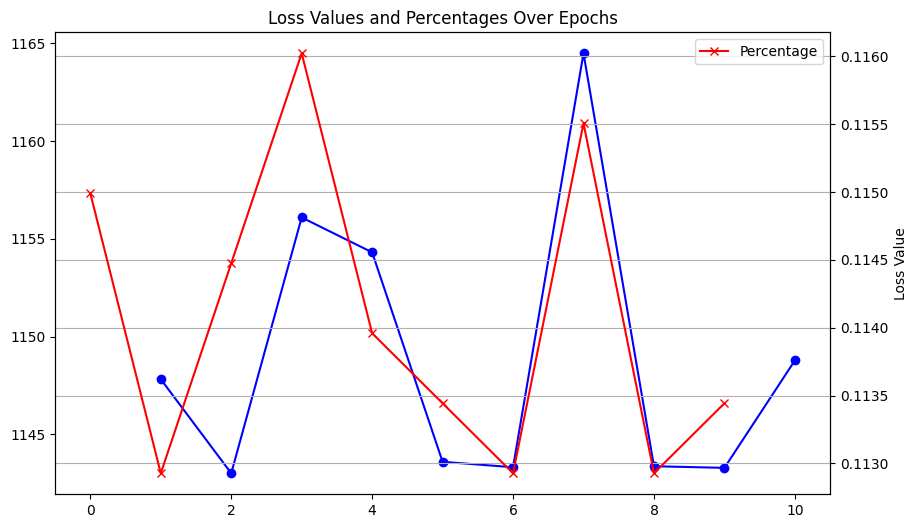

In [66]:
# Plotting
plt.figure(figsize=(10, 6))
x = [i+1 for i in range(epochs)]
# Plotting loss values
plt.plot(x, epoch_loss, marker='o', linestyle='-', color='b', label='Loss Value')

# Adding second y-axis for percentages
ax2 = plt.gca().twinx()
ax2.plot(range(epochs), epoch_nonzero, marker='x', linestyle='-', color='r', label='Percentage')
ax2.set_ylabel('Nonzero (%)')

# Setting the labels and titles
plt.title('Loss Values and Percentages Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.grid(True)

# Adding a legend
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()



In [67]:
# Generate predictions and save them in a pandas dataframe along with their true values
model.eval()
with torch.no_grad():
  true = []
  prd = []
  for x, y in test_generator:
    x, y = x.to(device), y.to(device)

    outputs = model(x.float())
    true.append(y.cpu().numpy())
    prd.append(outputs.cpu().numpy())

true = np.concatenate(true)
prd = np.concatenate(prd)
outputs = pd.DataFrame({'true': true.flatten(), 'pred': prd.flatten()})
nonzero = outputs[outputs['pred'] > 0]

print(f"{round(100 * nonzero.shape[0] / outputs.shape[0], 2)}% are nonzero")
if nonzero.shape[0] > 0:
  nz_true, nz_pred = nonzero['true'], nonzero['pred']

  nz_error = np.sum(np.abs(nz_true - nz_pred)) / nonzero.shape[0]
  print(f"nonzero error: {round(nz_error, 2)}")

11.44% are nonzero
nonzero error: 7.8


In [68]:
outputs.shape

(3882, 2)

In [69]:
nonzero.head(10)

,true,pred
1,13,3.041416
7,10,3.850411
8,7,2.722318
23,5,1.584601
24,4,2.633987
36,4,3.457696
44,17,2.835007
64,14,2.256834
74,6,3.626811
80,11,2.809390


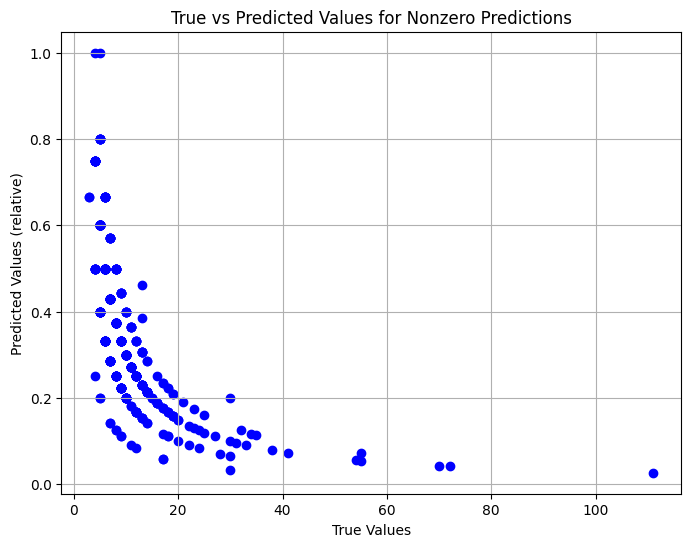

In [70]:
zero = outputs[outputs['pred'] == 0]

plt.figure(figsize=(8, 6))
plt.scatter(nonzero['true'], np.round(nonzero['pred']) / nonzero['true'], color='blue')
# plt.scatter(zero['true'], zero['pred'], color='red', label='Zero Predictions')
plt.title('True vs Predicted Values for Nonzero Predictions')
plt.xlabel('True Values')
plt.ylabel('Predicted Values (relative)')
plt.grid(True)
plt.show()

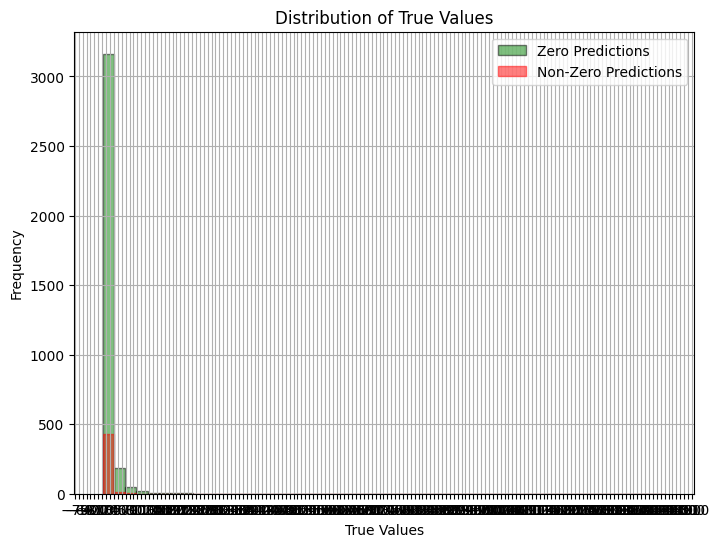

In [71]:
plt.figure(figsize=(8, 6))

# Determine the common range for both histograms
min_true = min(zero['true'].min(), nonzero['true'].min())
max_true = max(zero['true'].max(), nonzero['true'].max())

# Define common bins for both histograms
bins = np.linspace(min_true, max_true, 51)  # 50 bins between min and max

# Plot both histograms
plt.hist(zero['true'], bins=bins, color='green', edgecolor='black', alpha=0.5, label='Zero Predictions', rwidth=1)
plt.hist(nonzero['true'], bins=bins, color='red', edgecolor='red', alpha=0.5, label='Non-Zero Predictions', rwidth=1)

plt.title('Distribution of True Values')
plt.xlabel('True Values')
plt.ylabel('Frequency')

# Customize x-axis ticks
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(10)) # Set interval of major ticks

plt.legend()
plt.grid(True)
plt.show()
